In [1]:
# Authors: Samantha Tetef and Vikram Kashyap
# Date: Winter 2020-2021 to Summer 2021

In [2]:
import warnings
warnings.filterwarnings("ignore")

from utils import *
from importlib import reload
# to reload utils, run:
import utils
utils = reload(utils)
from utils import *

import os
import copy
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.colors import to_hex
from matplotlib.colors import ListedColormap
import mplcursors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy

from itertools import compress

from pathlib import Path

import webbrowser

warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

In [4]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

XES_DATA = get_Data(Listdir, mode='xes')
XANES_DATA = get_Data(Listdir, mode='xanes')

# CIDS = np.array(get_Property(XES_DATA, 'CID'))
# compoundtypes = get_Property(XES_DATA, 'Type')
# compoundclasses = get_Property(XES_DATA, 'Class')

CIDS = np.array(get_Property(XES_DATA, 'CID', applyfilter=exclude_None_class))
compoundtypes = get_Property(XES_DATA, 'Type', applyfilter=exclude_None_class)
compoundclasses = get_Property(XES_DATA, 'Class', applyfilter=exclude_None_class)

In [5]:
transitions = get_Property(XANES_DATA, 'Transitions')

In [6]:
good, bad = 0, 0
diff = []
for trans in transitions:
    x, y = trans
    whiteline_E = x[np.argmax(y[:-5])]
    max_E = whiteline_E + 15
    num_above_threshold = np.sum(x > max_E)
    
    last_trans = x[0]
    diff.append(max_E - last_trans)
    
    if num_above_threshold > 0:
        good += 1
    else:
        bad += 1
diff = np.array(diff)

In [7]:
print(f'{good} good vs {bad} bad')
print(np.average(diff), ' +/- ', np.std(diff))

164 good vs 612 bad
2.2258978092783432  +/-  8.23847497933549


In [8]:
CIDS.shape

(698,)

# Visualization of Classification Distributions

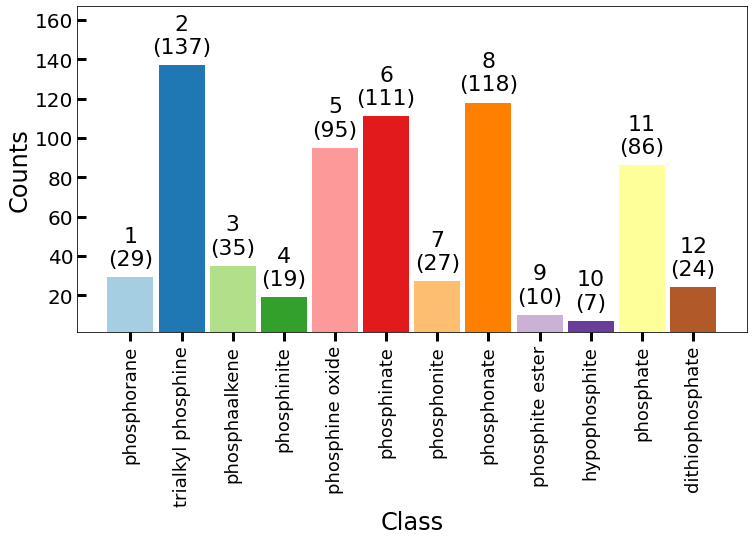

In [9]:
categorizer = compoundclasses

classnames = list(TYPECODES.keys())[:-1]
bins = [np.sum(np.array(categorizer)==classname) for classname in classnames]
    
hist(bins, [c.replace('_', ' ') for c in classnames], label='Class', verbose=True)

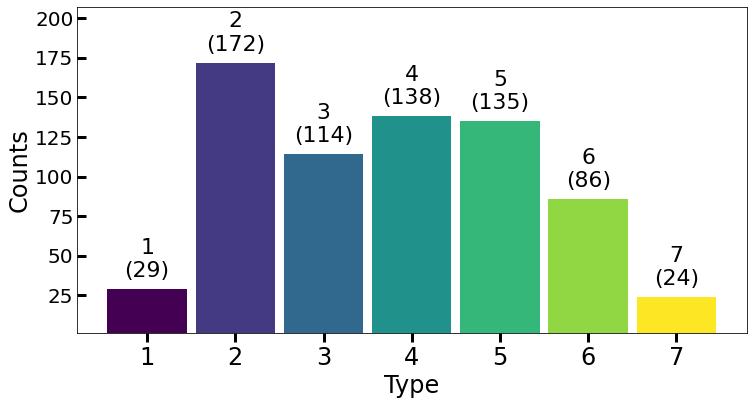

In [10]:
categorizer = compoundtypes

classnames = np.unique(list(TYPECODES.values()))[:-1]
bins = [np.sum(np.array(categorizer)==classname) for classname in classnames]

hist(bins, classnames, label='Type', verbose=True)

In [11]:
num = 0
for i, Type in enumerate(compoundtypes):
    if Type==6:
        print(CIDS[i])
        num += 1
    if num == 10:
        break

13708
118987337
11458565
135451578
1053
123912
11550267
122271
119401
122250


In [12]:
xes = np.array(get_Property(XES_DATA, 'Spectra', applyfilter=exclude_None_class))
# xes = np.array(get_Property(XES_DATA, 'Spectra'))
XESenergy = xes[0,0,:]
XES = xes[:,1,:]

XES_SCALING = np.max(XES)
XES = XES / XES_SCALING

In [13]:
xanes = np.array(get_Property(XANES_DATA, 'Spectra', applyfilter=exclude_None_class))
# xanes = np.array(get_Property(XANES_DATA, 'Spectra'))
XANESenergy = xanes[0,0,:]
XANES = xanes[:,1,:]

XANES_SCALING = np.max(XANES)
XANES = XANES / XANES_SCALING

### Check calulcations

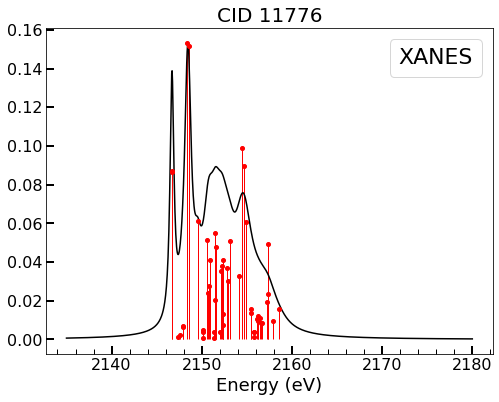

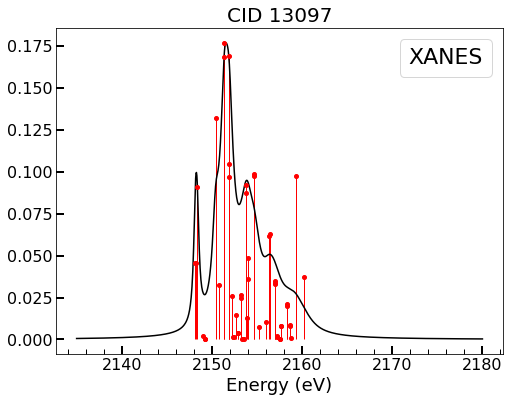

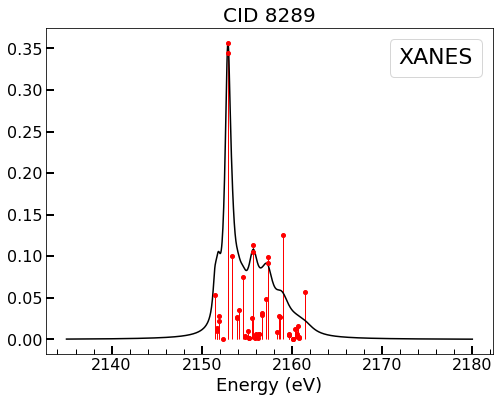

In [14]:
mycids = [11776, 13097, 8289]
all_CIDS = np.array(get_Property(XES_DATA, 'CID'))
for cid in mycids:
    
    i = np.where(all_CIDS==cid)[0][0]
    j = np.where(CIDS==cid)[0][0]
    
#     trans = XES_DATA[i]['Transitions']
#     trans = esnip(trans, XES[i], mode='xes', emin=2100)
#     plot_spectrum_and_trans([XESenergy, XES[i]], trans, f'{CIDS[i]}', label='VtC-XES')
    
    trans = XANES_DATA[i]['Transitions']
    trans = esnip(trans, XANES[j], energy=XANESenergy, mode='xanes')
    plot_spectrum_and_trans([XANESenergy, XANES[j]], trans, f'{CIDS[j]}', label='XANES')

# Theory and Experiment Comparison

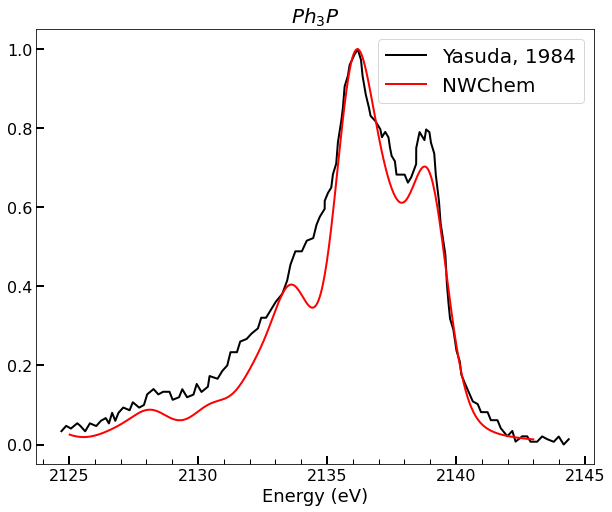

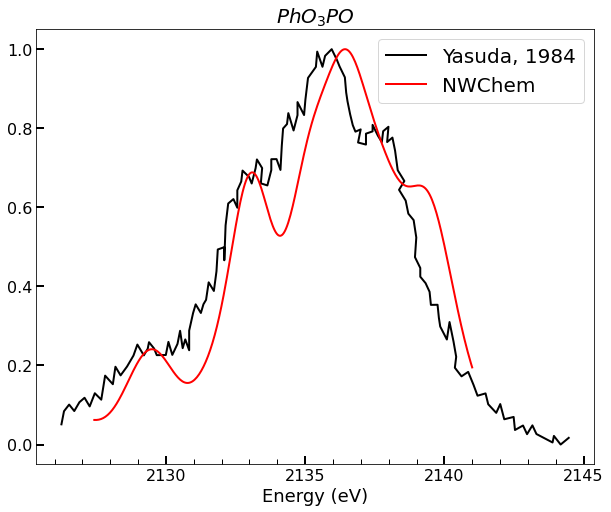

In [15]:
df1 = pd.read_csv('Ph3P.csv')
df2 = pd.read_csv('Ph3PO.csv')
df3 = pd.read_csv('PhO3PO.csv')

hc = 1.23984193e-6 #ev/m
d = 6.5327e-10 #m
def to_energy(two_theta):
    return hc/(d*np.sin(two_theta*(np.pi/180)/2))


def stack_plot(Spectrums, Labels, title=None,
               verbose=True, label=None, peaknorm=True):
    
    n = len(Spectrums)
    Colors=plt.cm.viridis(np.arange(n)/(n+1))
    if n == 2:
        Colors=['black', 'red']
    fig, ax = plt.subplots(figsize=(10,8))

    i = 0
    for spectrum in Spectrums:
        x, y = spectrum
        if peaknorm:
            y = y/np.max(y)
        ax.plot(x, y, '-', color=Colors[i], linewidth=2, label=Labels[i])
        i += 1

    if title is not None:
        plt.title(title, fontsize=20)
    plt.xlabel('Energy (eV)', fontsize=18)
    plt.tick_params(labelsize=16)

    if verbose:
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.tick_params(direction='in', width=1, length=5, which='minor')

    ax.tick_params(direction='in', width=2, length=8, which='major')

    plt.legend(fontsize=20)
    
    plt.show()

    
####################### spectrum 1
x = to_energy(df1['2theta'].values)
y = df1['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 350, 800
x2 = XESenergy[emin:emax]
i = np.where(CIDS==mycids[0])[0][0]
y2 = XES[i][emin:emax]
e_shift = x2[np.argmax(y2)] - x[np.argmax(y)]
stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$Ph_3P$")

####################### spectrum 2
x = to_energy(df3['2theta'].values)
y = df3['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 410, 750
x2 = XESenergy[emin:emax]
i = np.where(CIDS==mycids[2])[0][0]
y2 = XES[i][emin:emax]
stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$PhO_3PO$", verbose=True)

# ML and Data Science section

## All Spectra Together

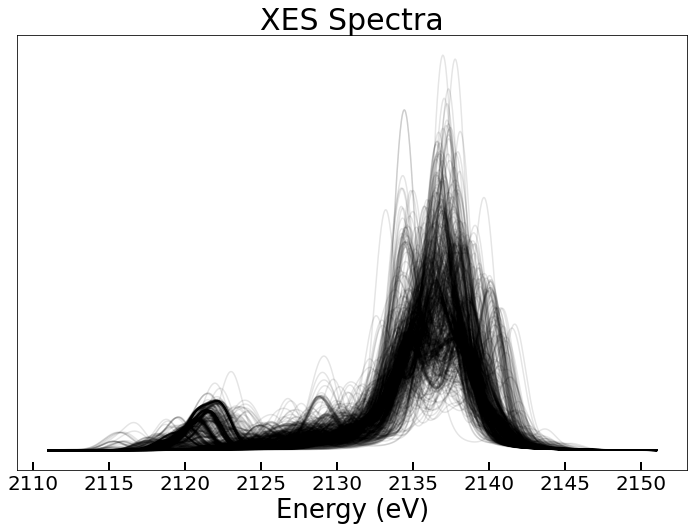

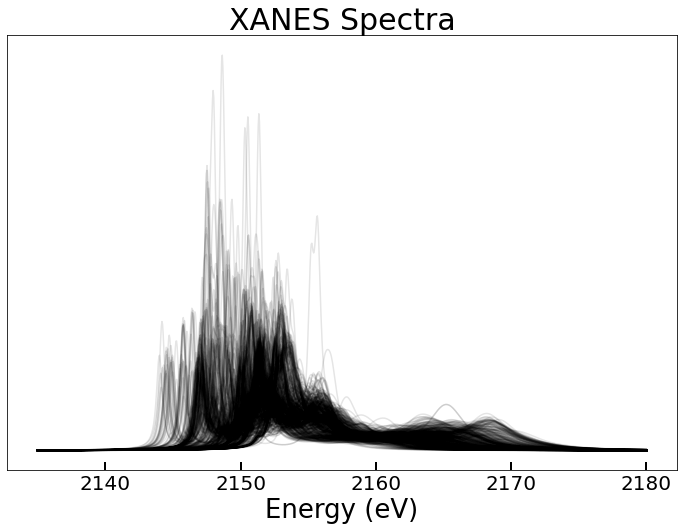

In [16]:
def Spagetti_plot(energy, X, mode='XES', MINIMAX=[0,-1]):
    
    MIN, MAX = MINIMAX
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    for x in X:
        plt.plot(energy, x, '-', c='k', alpha=0.1)
                
    plt.title(f"{mode} Spectra", fontsize=30)
    
    plt.xlabel('Energy (eV)', fontsize=26)
    plt.xticks(fontsize=20)
    ax.tick_params(direction='in', width=2, length=8)
    plt.yticks([])

    plt.show()
    
Spagetti_plot(XESenergy, XES, mode='XES')
Spagetti_plot(XANESenergy, XANES, mode='XANES')

## Rainbow Spaghetti Plot: Color and Stack by Compound Type

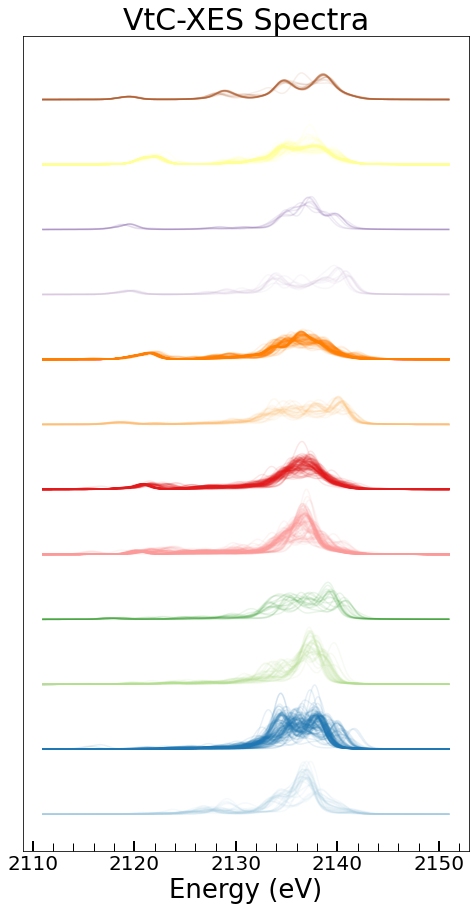

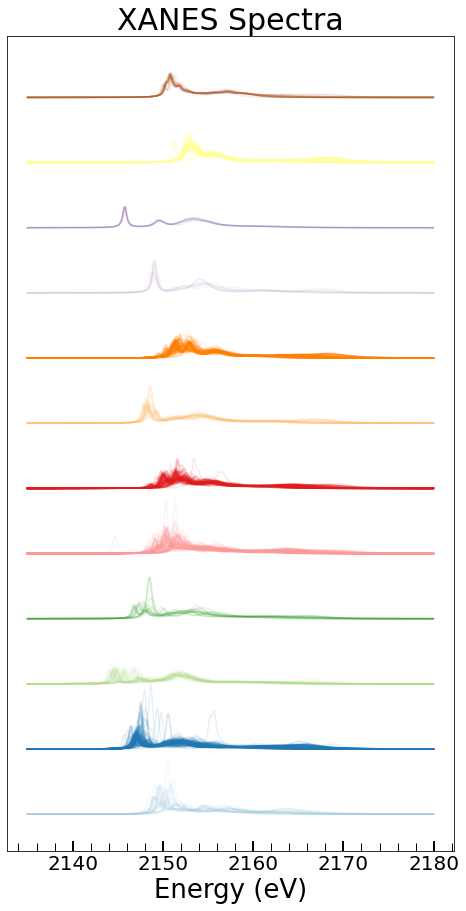

In [17]:
Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)),
                                   XESenergy, XES, compoundclasses, CIDS, mode='VtC-XES', cmap=CMAP2);
Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)),
                                   XANESenergy, XANES, compoundclasses, CIDS, mode='XANES', cmap=CMAP2);

# ML Reduced Space: PCA and t-SNE

In [18]:
warnings.filterwarnings("ignore")
# pca
pca1 = PCA(n_components=2)
XES_PCA = pca1.fit_transform(XES)

# pca
pca2 = PCA(n_components=2)
XANES_PCA = pca2.fit_transform(XANES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
XES_TSNE = tsne.fit_transform(XES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
XANES_TSNE = tsne.fit_transform(XANES)

In [19]:
def onselect(sel):
    sel.annotation.set_text( \
    str(CIDS[sel.target.index])+','+str(compoundclasses[sel.target.index]))
    webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[sel.target.index]}&t=l")      

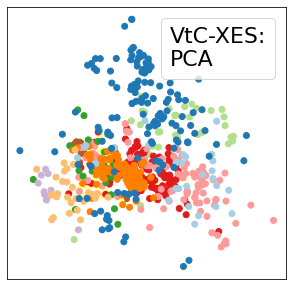

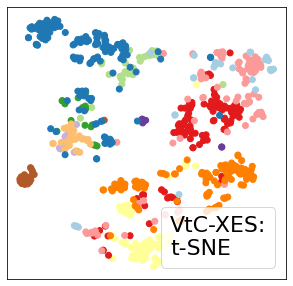

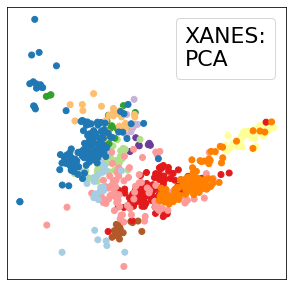

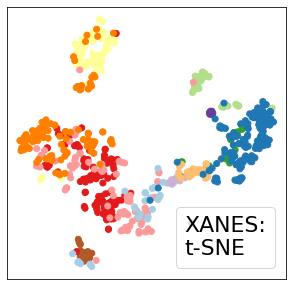

<function __main__.onselect(sel)>

In [20]:
cmap = CMAP2
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)),
                               XES_PCA, compoundclasses, 'PCA', cmap=cmap)).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)),
                               XES_TSNE,compoundclasses, 't-SNE', cmap=cmap)).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)),
                               XANES_PCA, compoundclasses, 'PCA', cmap=cmap, mode='XANES')).connect("add", onselect)
mplcursors.cursor(plot_dim_red(plt.subplots(figsize=(5,5)),
                               XANES_TSNE, compoundclasses, 't-SNE', cmap=cmap, mode='XANES')).connect("add", onselect)

## Spectra + Reduced Space Combined

In [21]:
# %matplotlib notebook

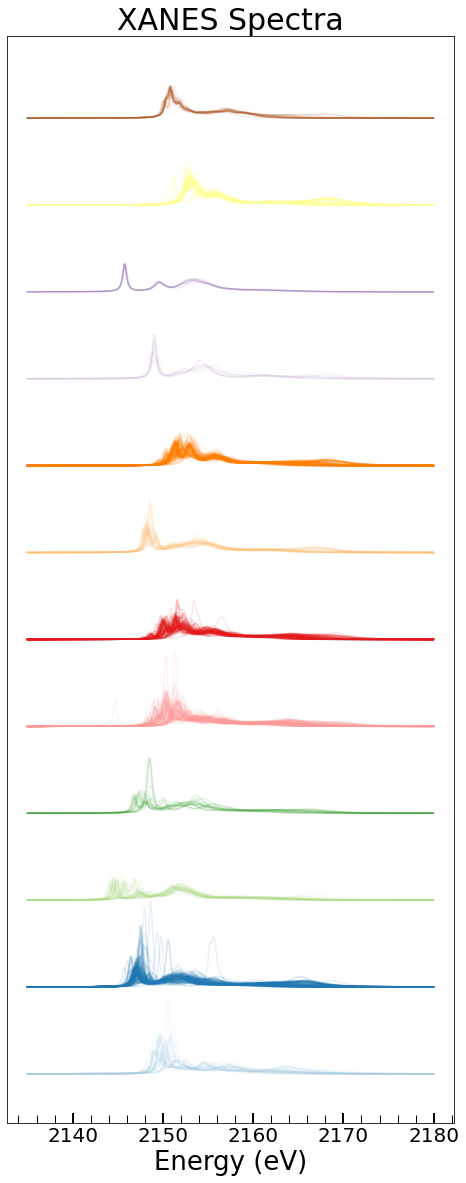

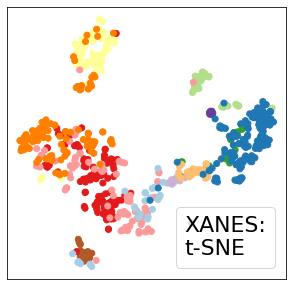

<function __main__.highlight_dot(sel)>

In [22]:
linktopubchem = True

oldlineprops = {}

def highlight_spectra(sel):
    sel.annotation.set_text( \
        str(CIDS[sel.target.index])+','+str(compoundclasses[sel.target.index]))
    if oldlineprops:
        spectra_lines[oldlineprops['index']].set_linewidth(oldlineprops['linewidth'])
        spectra_lines[oldlineprops['index']].set_color(oldlineprops['color'])
        spectra_lines[oldlineprops['index']].set_alpha(oldlineprops['alpha'])
    oldlineprops['index'] = sel.target.index
    oldlineprops['linewidth'] = spectra_lines[sel.target.index].get_lw()
    oldlineprops['color'] = spectra_lines[sel.target.index].get_c()
    oldlineprops['alpha'] = spectra_lines[sel.target.index].get_alpha()
    spectra_lines[sel.target.index].set_linewidth(3)
    spectra_lines[sel.target.index].set_color('k')
    spectra_lines[sel.target.index].set_alpha(1)
    if linktopubchem:
        webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[sel.target.index]}&t=l")

def unhighlight_spectra(sel):
    spectra_lines[sel.target.index].set_linewidth(oldlineprops['linewidth'])
    spectra_lines[sel.target.index].set_color(oldlineprops['color'])
    spectra_lines[sel.target.index].set_alpha(oldlineprops['alpha'])
        

olddotprops = {}

def highlight_dot(sel):
    #sel.annotation.set_text(str(CIDS[sel.target.index])+' '+str(types[sel.target.index]))
    if olddotprops:
        redspace_dots.set_edgecolors(olddotprops['colors'])
    olddotprops['colors'] = copy.deepcopy(redspace_dots.get_edgecolors())
    newdotedgecolors = copy.deepcopy(olddotprops['colors'])
    #webbroswer.open(str(len(olddotedgecolors)))
    #webbrowser.open(repr(sel.artist.get_label().split(',')[0]))
    index = CIDS.index(int(sel.artist.get_label().split(',')[0]))
    newdotedgecolors[index] = [1,0,0,1]
    redspace_dots.set_edgecolors(newdotedgecolors)
    if linktopubchem:
        webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={CIDS[index]}&t=l")


def unhighlight_dot(sel):
    webbrowser.open('test')
    redspace_dots.set_edgecolors(olddotprops['colors'])
    
spectra_lines = Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,20)), XANESenergy, XANES,
                                                   compoundclasses, CIDS, mode='XANES', cmap=CMAP2)
redspace_dots = plot_dim_red(plt.subplots(figsize=(5,5)), XANES_TSNE,
                             compoundclasses, 't-SNE', mode='XANES', cmap=CMAP2)

dotcursor = mplcursors.cursor(redspace_dots)
dotcursor.connect("add", highlight_spectra)
# dotcursor.connect("remove", unhighlight_spectra)

linecursor = mplcursors.cursor(spectra_lines, highlight=True,
                  highlight_kwargs={'color':'pink', 'alpha':1, 'linewidth':3, 'markeredgewidth':0})
linecursor.connect("add", highlight_dot)
#linecursor.connect("remove", unhighlight_dot)

In [23]:
# Uncomment and run the line below to stop it linking to PubChem when you click on the figures
# linktopubchem = True

In [24]:
%matplotlib inline

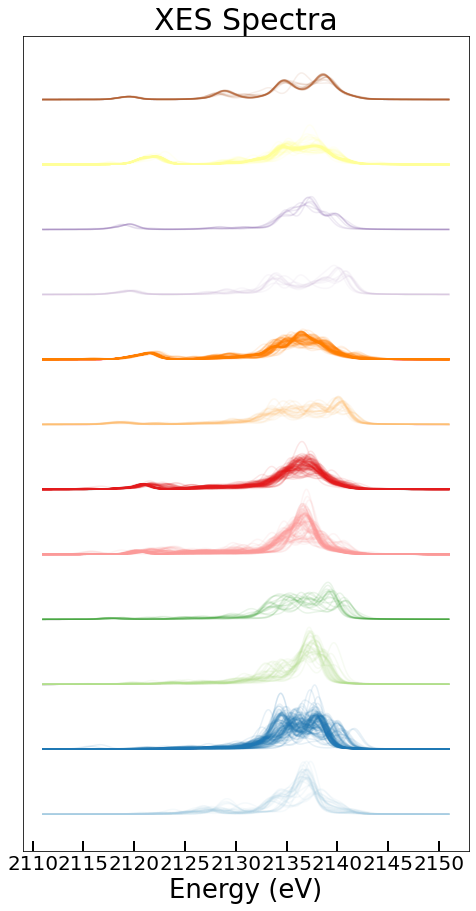

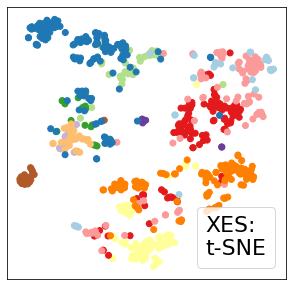

<function __main__.highlight_dot(sel)>

In [25]:
spectra_lines = Rainbow_spaghetti_plot_types_stack(plt.subplots(figsize=(8,15)), XESenergy, XES,
                                                   compoundclasses, CIDS, mode='XES', cmap=CMAP2)
redspace_dots = plot_dim_red(plt.subplots(figsize=(5,5)), XES_TSNE,
                             compoundclasses, 't-SNE', mode='XES', cmap=CMAP2)

dotcursor = mplcursors.cursor(redspace_dots)
dotcursor.connect("add", highlight_spectra)
#dotcursor.connect("remove", unhighlight_spectra)

linecursor = mplcursors.cursor(spectra_lines, highlight=True,
                  highlight_kwargs={'color':'pink', 'alpha':1, 'linewidth':3, 'markeredgewidth':0})
linecursor.connect("add", highlight_dot)

# Heirarchical Clustering

In [39]:
Z = linkage(XANES, method='ward')
# Z = linkage(XES, method='weighted', metric='cosine')

In [40]:
cmap = plt.cm.viridis(np.linspace(0, 1, 4))
hierarchy.set_link_color_palette([to_hex(rgb) for rgb in cmap])

In [41]:
p = 8
R = dendrogram(Z, truncate_mode='lastp', p=p, no_plot=True)
labels = np.arange(1,p + 1)
temp = {R["leaves"][ii]:(labels[ii], R["ivl"][ii]) for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}: {}".format(*temp[xx])

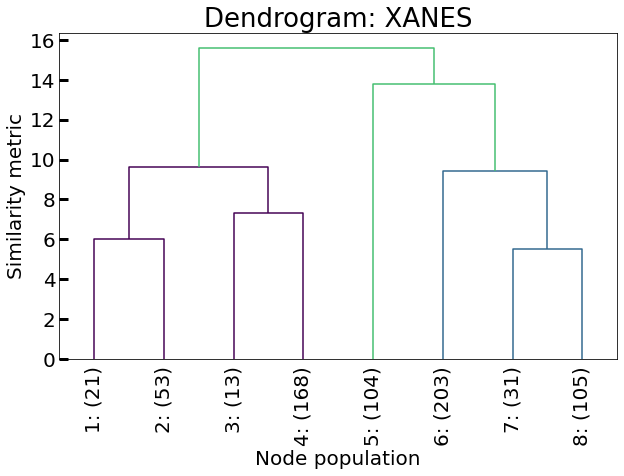

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Dendrogram: XANES', fontsize=26)

# plot the top levels of the dendrogram
result = dendrogram(Z, truncate_mode='lastp', p=p,
                    above_threshold_color=plt.cm.viridis(0.7),
                    leaf_label_func=llf,
                    leaf_rotation=90)

ax.tick_params(axis='y',direction='in', width=3, length=9)
plt.ylabel("Similarity metric", fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Node population", fontsize=20)
plt.xticks(fontsize=20)

plt.show()

In [43]:
cluster_labels = fcluster(Z, p, criterion='maxclust')

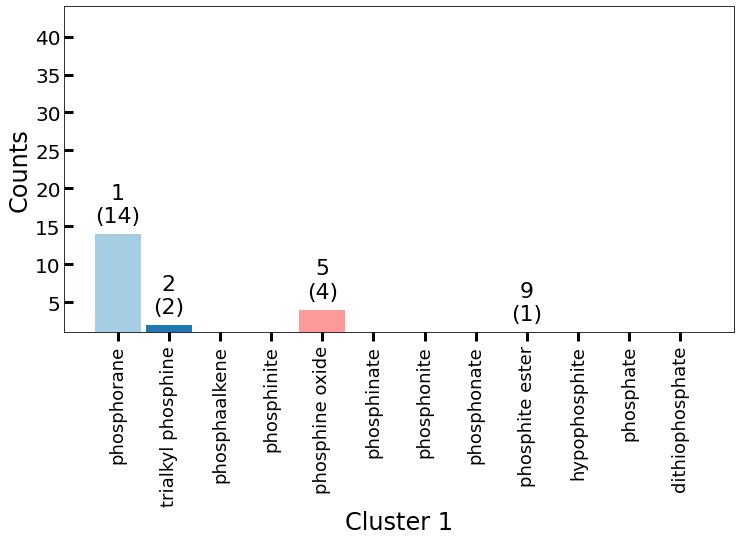

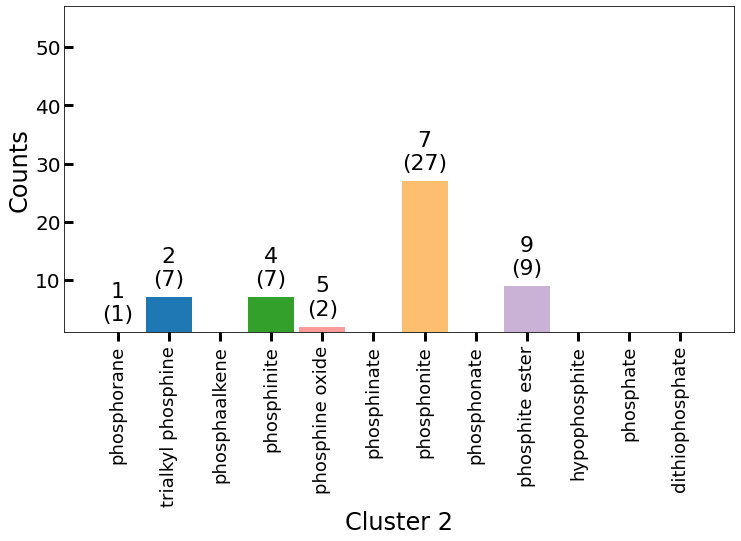

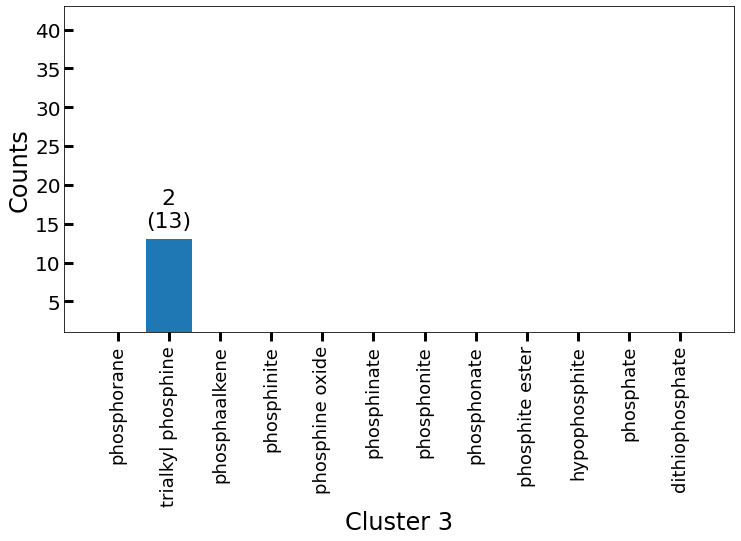

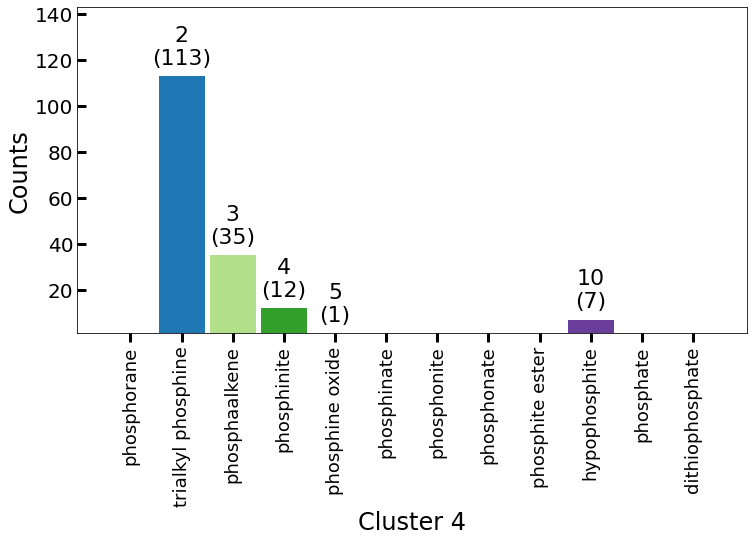

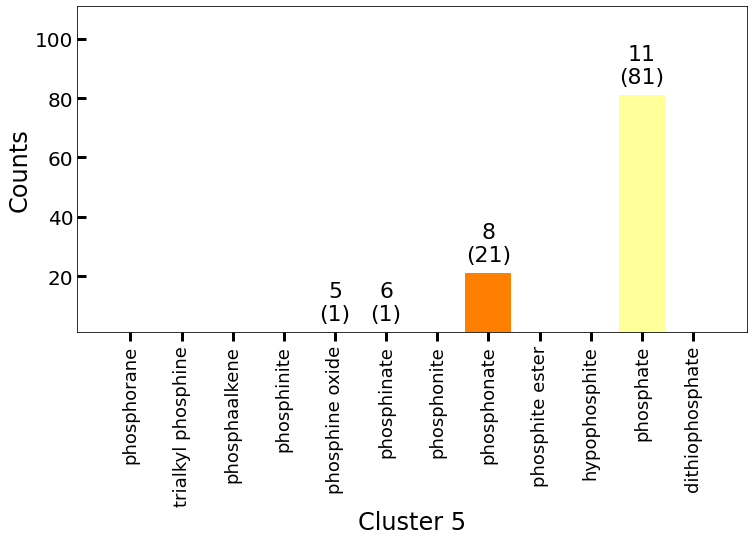

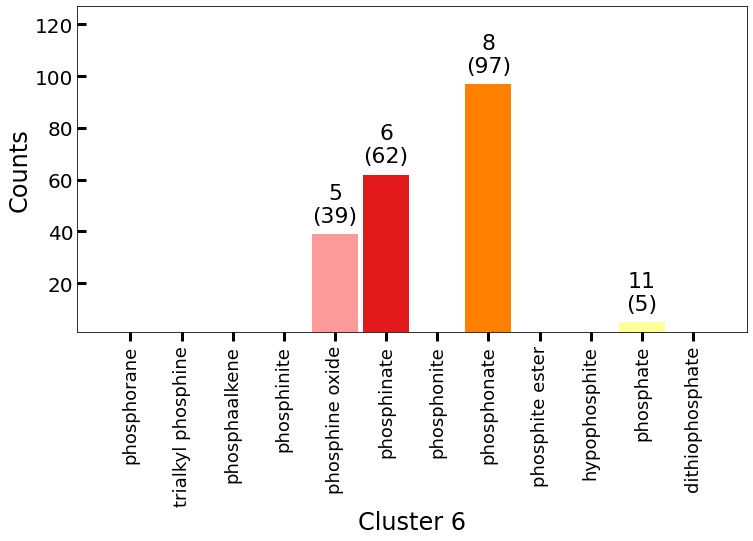

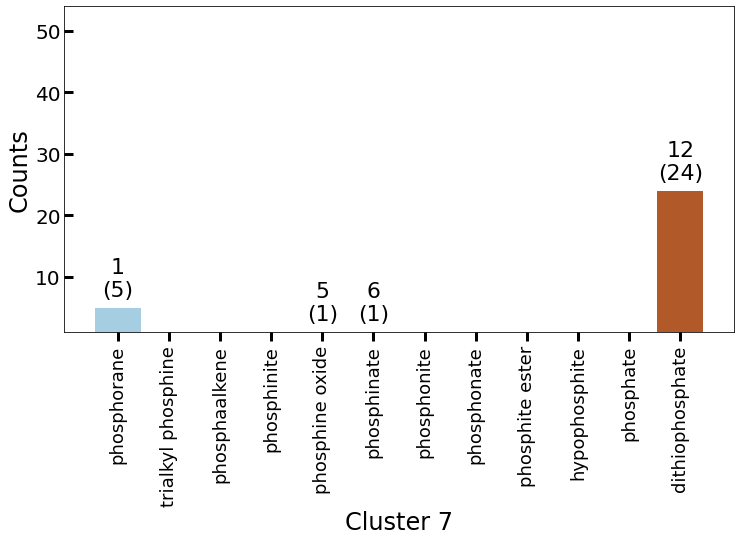

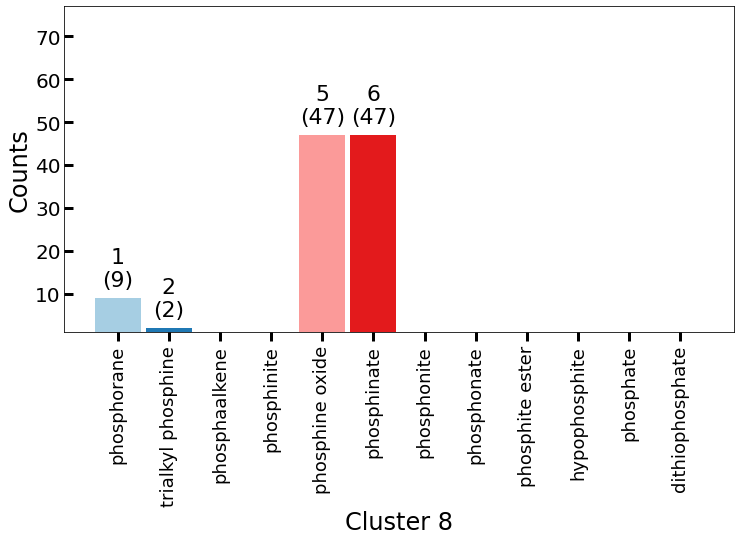

In [44]:
for i in range(1,p + 1):
    bool_arr = cluster_labels == i
    categorizer = list(compress(compoundclasses, bool_arr))

    classnames = list(TYPECODES.keys())[:-1]
    bins = [np.sum(np.array(categorizer)==classname) for classname in classnames]

    hist(bins, [c.replace('_', ' ') for c in classnames], label=f'Cluster {i}', verbose=True)